In [188]:
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")

<h3>Loading The Data</h3>

In [189]:
hospital_data = pd.read_excel('Hospital_dataset.xlsx', sheet_name='Hospital ER')

<h3>Some EDA Before Cleaning</h3>

In [190]:
hospital_data.isna().sum()

date                       0
patient_id                 0
patient_gender             0
patient_age                0
patient_sat_score       6699
patient_first_inital       0
patient_last_name          0
Full_Name                  0
Doctor                     0
patient_admin_flag         0
patient_waittime           0
department_referral     5401
revenue                    0
dtype: int64

In [191]:
print(f"Percent of missing Values in patient_sat_score: {(hospital_data['patient_sat_score'].isna().sum() / hospital_data.shape[0]) * 100:.2f}%")
print(f"Percent of missing Values in department_referral: {(hospital_data['department_referral'].isna().sum() / hospital_data.shape[0]) * 100:.2f}%")


Percent of missing Values in patient_sat_score: 72.68%
Percent of missing Values in department_referral: 58.60%


<h3>More Than 70% of the data is missing which means we can't drop it we should impute it by the right way</h3>

In [192]:
print(hospital_data.duplicated().sum())

0


<h3>There's no Duplicates to drop in the data</h3>

<h3>Copying The Data to Compare Before and After The Analysis</h3>

In [193]:
hospital_data_copy = hospital_data.copy()

In [213]:
hospital_data_copy.head(10)

,date,patient_id,patient_gender,patient_age,patient_sat_score,patient_first_inital,patient_last_name,Full_Name,Doctor,patient_admin_flag,patient_waittime,department_referral,revenue,imputed_depart,year,patient_category,imputed_sat
0,2020-03-20 08:47:00,145-39-5406,Male,69,10.0,H,Glasspool,H.Glasspool,Dr. Ben Carson,False,39,Gastroenterology,260,False,2020,Senior,False
1,2020-06-15 11:29:00,316-34-3057,Male,4,10.0,X,Methuen,X.Methuen,Dr. Mohamed Oz,True,27,Renal,275,False,2020,Child,False
2,2020-06-20 09:13:00,897-46-3852,Female,56,9.0,P,Schubuser,P.Schubuser,Dr. Patricia Bath,True,55,General Practice,260,False,2020,Adult,False
3,2020-02-04 22:34:00,358-31-9711,Female,24,8.0,U,Titcombe,U.Titcombe,Dr. Jennifer Doudna,True,31,General Practice,460,False,2020,Young Adult,False
4,2020-09-04 17:48:00,289-26-0537,Male,5,4.0,Y,Gionettitti,Y.Gionettitti,Dr. Joycelyn Elders,False,10,Orthopedics,275,False,2020,Child,False
5,2019-04-20 00:13:00,255-51-2877,Male,58,0.0,H,Buff,H.Buff,Dr. Paul Farmer,False,59,General Practice,260,False,2019,Adult,False
6,2019-08-23 08:26:00,465-97-0990,Female,68,10.0,F,Perrat,F.Perrat,Dr. Eric Topol,True,43,Cardiology,260,False,2019,Senior,False
7,2019-07-29 16:57:00,157-31-7520,Female,47,8.0,K,Gwillim,K.Gwillim,Dr. Lisa Sanders,True,23,Gastroenterology,460,False,2019,Adult,False
8,2020-02-19 06:54:00,432-34-5614,Female,79,1.0,E,Dewhirst,E.Dewhirst,Dr. Francis Collins,False,42,Physiotherapy,260,False,2020,Senior,False
9,2020-10-11 05:25:00,609-17-8678,Male,62,4.0,M,Crebo,M.Crebo,Dr. Joycelyn Elders,False,51,Physiotherapy,260,False,2020,Senior,False


<h3>Creating Year Column and setting other Columns to Categories</h3>

In [212]:
hospital_data_copy['imputed_depart'] = hospital_data_copy.apply(
    lambda row: True if pd.isna(row['department_referral']) else False,
    axis=1
)
hospital_data_copy['imputed_sat'] = hospital_data_copy.apply(
    lambda row: True if pd.isna(row['patient_sat_score']) else False,
    axis=1
)
hospital_data_copy['patient_gender'] = hospital_data_copy['patient_gender'].astype('category')
hospital_data_copy['patient_first_inital'] = hospital_data_copy['patient_first_inital'].astype('category')
hospital_data_copy['Doctor'] = hospital_data_copy['Doctor'].astype('category')
hospital_data_copy['department_referral'] = hospital_data_copy['department_referral'].astype('category')
hospital_data_copy['year'] = hospital_data_copy['date'].dt.year

In [196]:
hospital_data_copy['Full_Name'] = hospital_data_copy['Full_Name'].str.slice(0,1) +"."+ hospital_data_copy['Full_Name'].str.slice(1,)

In [197]:
hospital_data_copy['patient_sat_score'].fillna(np.NaN, inplace=True)

In [198]:
from imputing_method import sat_imputer

In [199]:
grouped_by_doc = hospital_data_copy.groupby('Doctor')

<h3>Imputing the Satisfaction Score with the mode of satisfaction score of every doctor's Patients</h3>

In [200]:
hospital_data_copy['patient_sat_score'] = hospital_data_copy['patient_sat_score'] = hospital_data_copy.apply(
    lambda row: sat_imputer(row, grouped_by_doc) if pd.isna(row['patient_sat_score']) else row['patient_sat_score'],
    axis=1
)

<h3>Creating the patient age category columns</h3>

In [201]:
labels = ['Child', 'Teen', 'Young Adult', 'Adult', 'Senior']
bins = [0, 13, 20, 36, 60, np.inf]
hospital_data_copy['patient_category'] = pd.cut(hospital_data_copy['patient_age'], bins=bins,labels=labels)

In [202]:
from imputing_method import imputer

<h3>Imputing department referral missing values by grouping the patients by the doctor and the age and gender to guess the best depart for the patient</h3>


In [203]:
hospital_data_copy['department_referral'] = hospital_data_copy['department_referral'] = hospital_data_copy.apply(
    lambda row: imputer(row, grouped_by_doc) if pd.isna(row['department_referral']) else row['department_referral'],
    axis=1
)

In [204]:
sns.set_style('darkgrid')

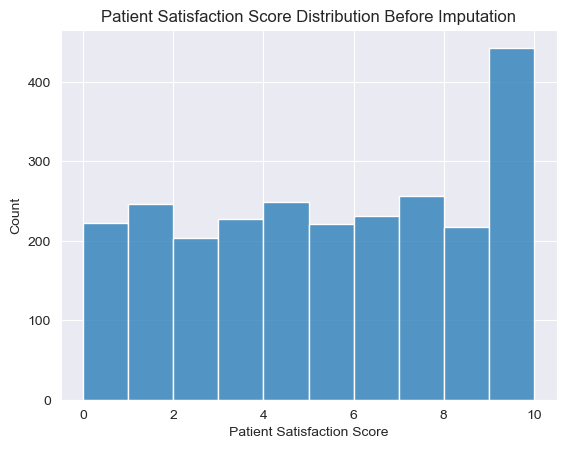

In [205]:
sns.histplot(data = hospital_data, x='patient_sat_score', binwidth=1, palette='Spectral')
plt.xlabel("Patient Satisfaction Score")
plt.title("Patient Satisfaction Score Distribution Before Imputation")
plt.show()

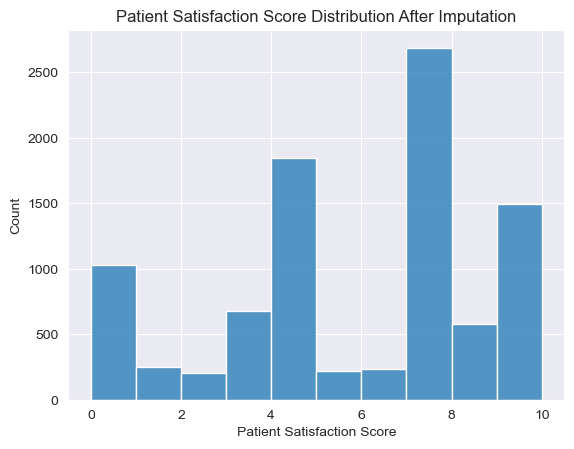

In [206]:
sns.histplot(data = hospital_data_copy, x='patient_sat_score', binwidth=1, palette='Spectral')
plt.xlabel("Patient Satisfaction Score")
plt.title("Patient Satisfaction Score Distribution After Imputation")
plt.show()

In [207]:
from scipy.stats import skew
skew(hospital_data_copy['patient_sat_score'])

-0.295194458669955

<h2>The Patient Satisfaction Score Is Slightly Negatively Skewed After The Imputation</h2>
<h3>Skewness Coefficient is -0.295</h3>


<h3>Visualizing the number of patients of 2020 VS 2019</h3>


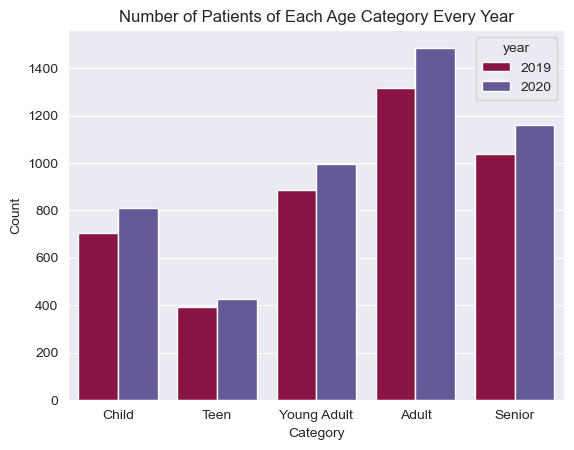

In [208]:
sns.countplot(data = hospital_data_copy, x = 'patient_category', hue = 'year', palette='Spectral')
plt.title("Number of Patients of Each Age Category Every Year")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

**WE CAN SEE THAT THE NUMBER OF PATIENTS IN 2020 IS MORE THAN IT IS IN 2019 WHICH REFERS TO A PANDEMIC OR AN EPIDEMIC**  

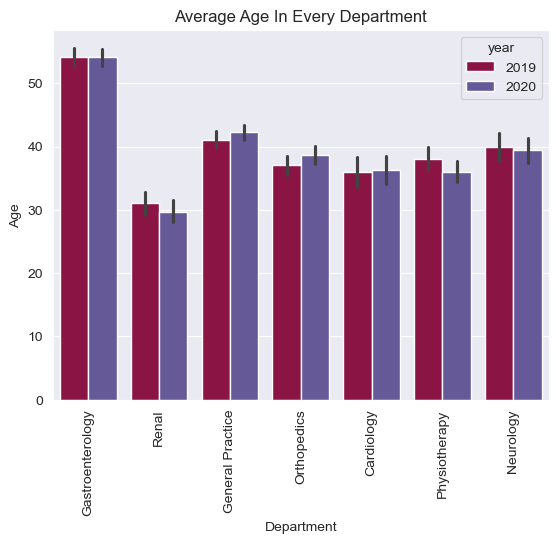

In [209]:
sns.barplot(data = hospital_data_copy, x = 'department_referral',y = 'patient_age', palette='Spectral', hue= 'year')
plt.title("Average Age In Every Department")
plt.xlabel("Department")
plt.ylabel("Age")
plt.xticks(rotation= 90)
plt.show()

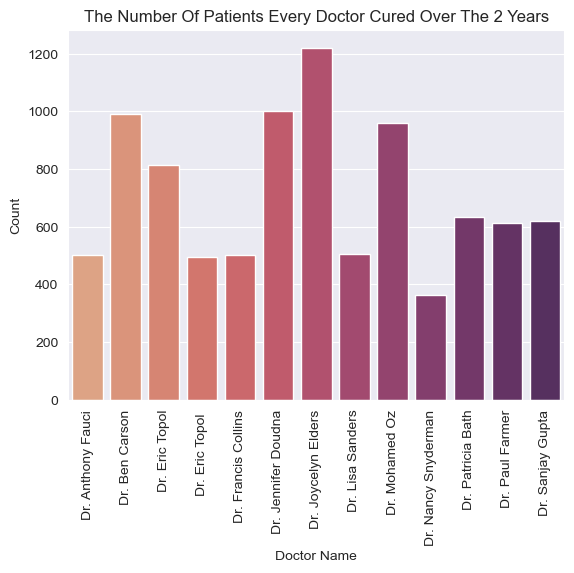

In [210]:
sns.countplot(data = hospital_data_copy, x = 'Doctor', palette='flare')
plt.title("The Number Of Patients Every Doctor Cured Over The 2 Years")
plt.xlabel("Doctor Name")
plt.ylabel("Count")
plt.xticks(rotation= 90)
plt.show()

**From The Plot We Can Tell That Dr.Joycelyn Elders Was The Doctor Of The Year**